<a href="https://colab.research.google.com/github/ucheokechukwu/courses/blob/main/Tensorflow_For_DeepLearning/09_NLP_Project_SkimLit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* https://dev.mrdbourke.com/tensorflow-deep-learning/09_SkimLit_nlp_milestone_project_2/

* https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/09_SkimLit_nlp_milestone_project_2.ipynb

1. Downloading the dataset
2. Writing a preprocessing function for our text data
3. Set up multiple modelling experiments with different levels of embedding
4. Building a multimodal model (taking multiple data inputs) - replicating this [this paper](https://arxiv.org/pdf/1612.05251.pdf)
5. Find the most wrong predictions
6. Make predictiosn on abstracts from the wild

# Milestone Project: Skim Lit 🔖🔥
Purpose of this project is to make medical abstracts easier to read.

Replicating these papers:

Replicating this paper: PubMed 200k RCT: [a Dataset for Sequenctial Sentence Classification in Medical Abstracts.](https://arxiv.org/abs/1710.06071) and paper on the [Architecture](https://arxiv.org/pdf/1612.05251.pdf)

In [1]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get data
We're replicating the paper above (PubMed 200k RCT), let's download the data they use.

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 23.92 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# check the files in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
# start our experiment with 20k_numbers_replaced_with_@_sign
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

# check all the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

# Preprocess data

In [5]:
from typing import List

In [6]:
# create function to read the lines of a document
def get_lines(filename: str) -> List[str]:
    """
    Reads filename (a text file) and returns the lines of text as a list
    args:
        filename: string containing the target filepath
    returns:
        a list of strings with one string per line
    """
    with open(filename, 'r') as f:
        t = f.readlines()
    return t


In [7]:
train_lines = get_lines(data_dir + 'train.txt')
text_lines = get_lines(data_dir + 'test.txt')
val_lines = get_lines(data_dir + 'dev.txt')
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

```python
[{'line_number': 0,
'target': 'BACKGROUND',
'text': 'Emotional eating is associated with overeating and the development of obesity.\n',
'total_lines': 11}]

```



In [8]:
def preprocess_text_with_line_numbers(filename: str):
    """
    Returns a list of dictionaries of abstract line data
    Takes a filename and return its content
    """
    input_lines = get_lines(filename)
    abstract_lines = "" # create an empty abstract
    abstract_samples = [] # create an empty list of abstracts

    # loop through each line in the target file
    for line in input_lines:
        if line.startswith("###"): # check to see if this is an ID line
            abstract_id = line
            abstract_lines = ""
        elif line.isspace():
            abstract_line_split = abstract_lines.split("\n")[:-1]


            total_lines = len(abstract_line_split)-1
            # iterate through each line in a single abstract

            for abstract_line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {} # empty dictionary for each line
                target_, text_ = abstract_line.split('\t')
                line_data['target'] = target_
                line_data['text'] = text_
                line_data['line_number'] = abstract_line_number
                line_data['total_lines'] = total_lines
                abstract_samples.append(line_data)

        else:
            abstract_lines += line
    return abstract_samples



In [9]:
train_samples = preprocess_text_with_line_numbers(data_dir+"train.txt")

test_samples = preprocess_text_with_line_numbers(data_dir+"test.txt")
val_samples = preprocess_text_with_line_numbers(data_dir+"dev.txt")
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
# turning data into a dataframe
import pandas as pd
train_df = pd.DataFrame.from_dict(train_samples)
test_df = pd.DataFrame.from_dict(test_samples)
val_df = pd.DataFrame.from_dict(val_samples)

In [11]:
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [12]:
# checking out the distribution of labels
train_df.target.value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

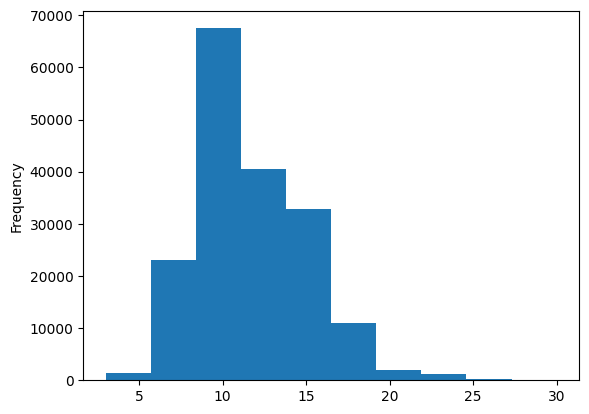

In [13]:
# let's check the length of different lines
train_df.total_lines.plot.hist();

### Get lists of sentences

In [14]:
# convert abstract text lines into lists
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()
assert len(train_sentences) == len(train_df)
assert len(val_sentences) == len(val_df)
assert len(test_sentences) == len(test_df)

In [15]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

## Making Numeric Labels

In [24]:
# one hot encode labels
import sklearn
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1,1))

In [25]:
test_labels_one_hot

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.]])

In [27]:
# label encode labels
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())

In [28]:
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [29]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

# Modelling Experiments

## Model 0: Baseline (TF-IDF Multinomial Naive Bayes Classifier)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
# create a pipeline
model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])
# fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [37]:
# evaluate baseline model on validation dataset
model_0.score(X=val_sentences,
                y=val_labels_encoded)

0.7218323844829869

In [38]:
# make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
# Download helper functions script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

from helper_functions import calculate_results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds,)
baseline_results

--2023-11-28 20:50:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-28 20:50:02 (60.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## Preparing our data (the text) for deep sequence models

In [39]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers


In [40]:
# how long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

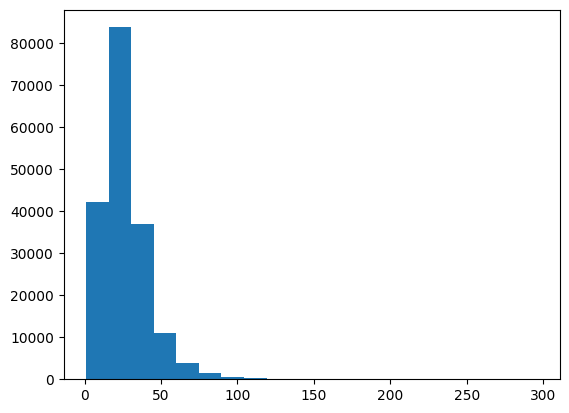

In [46]:
# what's the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20);

In [47]:
# use numpy percentile to get the word length that covers 95% of the data
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

### 1. Create a text vectorization layer
maps: words -> numbers

In [51]:
# taken from the paper, vocab size
max_tokens = 68000
# create text vectorizer
from tensorflow.keras.layers import TextVectorization
textvectorizer = TextVectorization(
    max_tokens = max_tokens,
    output_sequence_length =output_seq_len

)

# adapt text vectorizer to training sentences
textvectorizer.adapt(train_sentences)

In [96]:
# test out textvectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text: {textvectorizer(target_sentence)}")

Text:
Safety assessments were conducted through day @ .

Length of text: 8

Vectorized text: [136 657   9 198 313 108   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


In [90]:
# how many words in our training vocabulary
rct_20k_text_vocab = textvectorizer.get_vocabulary()

print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common: {rct_20k_text_vocab[:5]}")
print(f"Least common: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common: ['', '[UNK]', 'the', 'and', 'of']
Least common: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [91]:
# get the config of our text vectorizer
textvectorizer.get_config()

{'name': 'text_vectorization_1',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### 2. Create an embedding layer

In [92]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               # note different embedding sizes result in different number of parameters to train
                               output_dim=128,
                               mask_zero = True,
                               name = "token_embedding"
                               )


In [97]:
# testing it out
print(f"Show sentence before vectorization: \n {target_sentence}\n")
vectorized_sentence = textvectorizer([target_sentence])
print(f"Sentence after vectorization: \n {vectorized_sentence}")
print("Shape:", end="")
print(vectorized_sentence.shape)
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding: \n{embedded_sentence}")
print("Shape:", end="")
print(embedded_sentence.shape)

Show sentence before vectorization: 
 Safety assessments were conducted through day @ .

Sentence after vectorization: 
 [[136 657   9 198 313 108   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0]]
Shape:(1, 55)
Sentence after embedding: 
[[[-0.03847746 -0.04382343  0.00581985 ... -0.02263114 -0.01142927
   -0.00402736]
  [ 0.01553739  0.04899503  0.04489031 ... -0.03082233 -0.02184634
   -0.01784204]
  [-0.04120085 -0.00689005 -0.00812216 ... -0.00516637  0.02357948
   -0.02157819]
  ...
  [-0.03886396 -0.04020313  0.02236274 ...  0.00771112  0.01565709
   -0.01774717]
  [-0.03886396 -0.04020313  0.02236274 ...  0.00771112  0.01565709
   -0.01774717]
  [-0.03886396 -0.04020313  0.02236274 ...  0.00771112  0.01565709
   -0.01774717]]]
Shape:(1, 55, 128)


## Creating Datasets (making sure our data loads as fast as possible)

[Build Tensorflow input pipelines](https://www.tensorflow.org/guide/data)

[Better Performance with `tf.data` API](https://www.tensorflow.org/guide/data_performance)

In [107]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_labels_one_hot)
)
valid_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_labels_one_hot)
)
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_labels_one_hot)
)
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [109]:
# turn the TEnsorSliceDataset to Prefetched Datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [110]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embeddings

In [137]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape = (1), dtype=tf.string)
textvectors = textvectorizer(inputs) # vectorize or map text inputs to integers
token_embeddings = token_embed(textvectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding='same', activation='relu')(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the outpuyt of our feature vector from conv layer
outputs = layers.Dense(num_classes, activation='softmax')(x)
model_1 = tf.keras.Model(inputs, outputs)

# compile
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 55)                0         
 Vectorization)                                                  
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d_5 (Conv1D)           (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d_2  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                           

In [138]:
len(train_dataset)

5627

In [139]:
# fit the model
history_1 = model_1.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=3,
                        validation_data=valid_dataset,
                        validation_steps = int(0.1*len(valid_dataset))
                        )

Epoch 1/3
562/562 [==============================] - 80s 139ms/step - loss: 0.9153 - accuracy: 0.6413 - val_loss: 0.6871 - val_accuracy: 0.7380
Epoch 2/3
562/562 [==============================] - 72s 128ms/step - loss: 0.6607 - accuracy: 0.7545 - val_loss: 0.6291 - val_accuracy: 0.7736
Epoch 3/3
562/562 [==============================] - 72s 128ms/step - loss: 0.6180 - accuracy: 0.7745 - val_loss: 0.5958 - val_accuracy: 0.7862


In [140]:
# evaluate on validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.5979 - accuracy: 0.7870


[0.5979055762290955, 0.7870051860809326]

In [148]:
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs.shape
model_1_pred = tf.argmax( model_1_pred_probs, axis=1 )
display(model_1_pred.shape, model_1_pred_probs.shape)
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_pred)
model_1_results

945/945 [==============================] - 11s 11ms/step


TensorShape([30212])

(30212, 5)

{'accuracy': 78.70051635111876,
 'precision': 0.7836275506222483,
 'recall': 0.7870051635111877,
 'f1': 0.7844626444395987}

In [149]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

## 2. Model 2: Feature extraction with pretrained token embedding

In [221]:
import tensorflow_hub as hub
tfhub_embeddinglayer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                                      trainable=False,
                                      name='universal-sentence-encoder')
from tensorflow.keras.utils import plot_model

In [ ]:
random_train_sentence = random.choice(train_sentences)
print("Sentence before embedding: \n", random_train_sentence)
print("Sentence after embedding: \n")
use_embedded_sentence = tfhub_embeddinglayer([random_train_sentence])
print(use_embedded_sentence)
print(f"Length and shape: ", len(use_embedded_sentence), use_embedded_sentence.shape)

In [230]:
inputs = layers.Input(shape=[], dtype=tf.string)
use_embedded = tfhub_embeddinglayer(inputs)
x = layers.Dense(128, activation='softmax')(use_embedded)
outputs = layers.Dense(5, activation='softmax')(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2")
display (model_2.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None,)]                 0         
                                                                 
 universal-sentence-encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_33 (Dense)            (None, 128)               65664     
                                                                 
 dense_34 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


None

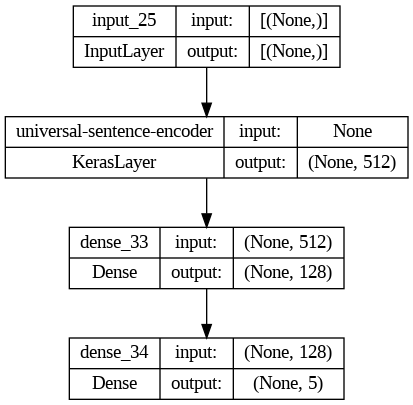

In [231]:
plot_model(model_2, show_shapes=True)

In [232]:
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics='accuracy')

In [233]:
history_2 = model_2.fit(train_dataset,
                        steps_per_epoch=int(0.1*len(train_dataset)),
                        epochs=3,
                        validation_data=valid_dataset,
                        validation_steps = int(0.1*len(valid_dataset))
                        )

Epoch 1/3
562/562 [==============================] - 15s 19ms/step - loss: 1.4468 - accuracy: 0.4713 - val_loss: 1.2647 - val_accuracy: 0.5183
Epoch 2/3
562/562 [==============================] - 11s 19ms/step - loss: 1.0929 - accuracy: 0.5953 - val_loss: 0.9888 - val_accuracy: 0.6223
Epoch 3/3
562/562 [==============================] - 11s 19ms/step - loss: 0.9532 - accuracy: 0.6294 - val_loss: 0.9098 - val_accuracy: 0.6406


In [234]:
# evaluating on the entire validation dataset
model_2.evaluate(valid_dataset)

945/945 [==============================] - 20s 21ms/step - loss: 0.9108 - accuracy: 0.6440


[0.9108455181121826, 0.6439825296401978]

In [238]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs.shape
model_2_pred = tf.argmax( model_2_pred_probs, axis=1 )
display(model_2_pred.shape, model_2_pred_probs.shape)
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_pred)
model_2_results

945/945 [==============================] - 15s 16ms/step


TensorShape([30212])

(30212, 5)

{'accuracy': 64.39825235005958,
 'precision': 0.6458489892316795,
 'recall': 0.6439825235005958,
 'f1': 0.6110039158891966}

In [237]:
model_1_results, baseline_results

({'accuracy': 78.70051635111876,
  'precision': 0.7836275506222483,
  'recall': 0.7870051635111877,
  'f1': 0.7844626444395987},
 {'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294})